In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [50]:
normal_df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/normal_run_data.csv')
normal_df['label']='R'
normal_df=normal_df.drop(columns=['DLC', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'])

DoS_df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/DoS_dataset.csv')
DoS_df=pd.concat([DoS_df.iloc[:,0:2],DoS_df.iloc[:,-1]],axis=1)
DoS_df.columns=['Timestamp','ID','label']
DoS_df.head()

,Timestamp,ID,label
0,1.478198e+09,018f,R
1,1.478198e+09,0260,R
2,1.478198e+09,02a0,R
3,1.478198e+09,0329,R
4,1.478198e+09,0545,R


In [25]:
DoS_df.dtypes

Timestamp    float64
ID            object
label         object
dtype: object

In [29]:
def h2i(s):
    return int(s,16)

def d2t(s):
  return pd.Timestamp(s,unit="s")

def s2i(s):
    if s=='R':
      return 0
    else:
      return 1

In [51]:
normal_df['ID']=normal_df['ID'].apply(h2i)
DoS_df['ID']=DoS_df['ID'].apply(h2i)
normal_df['Timestamp']=normal_df['Timestamp'].apply(d2t)
DoS_df['Timestamp']=DoS_df['Timestamp'].apply(d2t)

In [45]:
normal_df.head()

,Timestamp,ID,label
0,2016-11-14 11:03:54.850201845,848,R
1,2016-11-14 11:03:54.850423098,704,R
2,2016-11-14 11:03:54.850976944,1072,R
3,2016-11-14 11:03:54.851215124,1201,R
4,2016-11-14 11:03:54.851463079,497,R


In [46]:
normal_df.dtypes

Timestamp    datetime64[ns]
ID                    int64
label                object
dtype: object

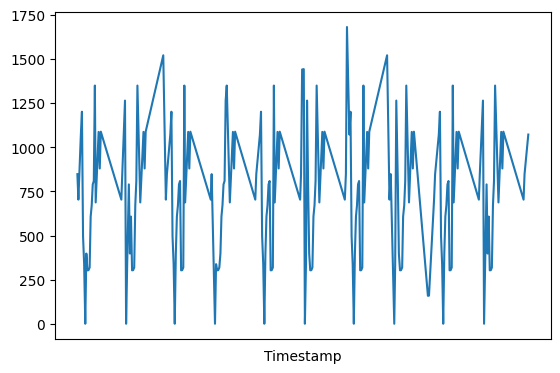

In [47]:
plot_features = normal_df['ID'][0:200]
plot_features.index = normal_df['Timestamp'][0:200]
_ = plot_features.plot(subplots=True)

In [54]:
normal_df.shape,DoS_df.shape
train=normal_df
test=DoS_df

((988742, 3), (3665770, 3))

In [55]:
scaler = StandardScaler()
scaler = scaler.fit(train[['ID']])

train['ID'] = scaler.transform(train[['ID']])
test['ID'] = scaler.transform(test[['ID']])

NameError: name 'StandardScaler' is not defined

In [ ]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['ID']], train['ID'])
X_test, y_test = create_sequences(test[['ID']], test['ID'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['ID'] = test[TIME_STEPS:]['ID']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=scaler.inverse_transform(test_score_df['ID']), name='ID'))
fig.add_trace(go.Scatter(x=anomalies['Timestamp'], y=scaler.inverse_transform(anomalies['ID']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()